This script is to map the fire data w weather data
- Input Data: 
    - "Extended_Data/Ignition/calfire_ign_1994_2020"
    - Raw Weather data to get weather grid: ../Extended_Data/Weather/wind_speed.1994.2000.CA.nc
- Output Dara: 
    - "../Clean_Data/Fire_Data/Extended/calfire_fod_fpa_1994_2020_dedup.parquet"
    - "../Clean_Data/Fire_Data/Extended/calfire_fod_fpa_1994_2020_dedup_map_weather_grid.parquet"

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [21]:
from scipy.spatial import cKDTree
from datetime import datetime

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [5]:
# example to use geodesic()
from geopy.distance import geodesic

# Define the coordinates
coords_1 = (40.452058, -124.374975)
coords_2 = (40.41039, -124.374975)

# Calculate the distance
distance = geodesic(coords_1, coords_2).km

# Print the distance
print(f"Distance: {distance} km")

Distance: 4.626936837923472 km


## Generate Summary Data

In [8]:
# You need the 'simpledbf' or 'dbfread' package. Install with: pip install dbfread
from dbfread import DBF

In [6]:
data_dir = '../../Extended_Data/Ignition/'
files = os.listdir(data_dir)
files

['calfire_ign_1994_2020.cpg',
 'calfire_ign_1994_2020.dbf',
 'calfire_ign_1994_2020.dbf.xml']

In [10]:
# Read the DBF file (attributes only, no geometry)
dbf_path = data_dir + 'calfire_ign_1994_2020.dbf'
table = DBF(dbf_path, encoding='utf-8')  # Try 'utf-8' or 'latin1' if you get encoding errors
# Convert to pandas DataFrame
calfire_dat = pd.DataFrame(iter(table))

In [12]:
calfire_dat.shape

(232807, 37)

In [24]:
log_messages = []
log_messages.append(f"Task: Data cleaning on {data_dir} with matched weather grid")
log_messages.append(f"Processing started on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [25]:
log_messages.append("=" * 50)
log_messages.append(f"Include only human-caused ignitions.")
log_messages.append(f"Original data shape: {calfire_dat.shape}")
log_messages.append(f"Unique values in 'NWCG_CAUSE': {calfire_dat['NWCG_CAUSE'].unique()}")


calfire_dat = calfire_dat[calfire_dat['NWCG_CAUSE'] == 'Human']

log_messages.append(f"Filtered data shape: {calfire_dat.shape}")
log_messages.append(f"Unique values in 'NWCG_CAUSE' after filtering: {calfire_dat['NWCG_CAUSE'].unique()}")

In [66]:
log_messages.append("=" * 50)
log_messages.append(f"Dedup based on selected columns.")


cols_to_keep = ['FOD_ID','FIRE_YEAR', 'DISCOVERY_', 'NWCG_CAUSE', 'NWCG_GENER',
       'CONT_DATE', 'FIRE_SIZE', 
       'LATITUDE', 'LONGITUDE', 'STATE']
calfire_dat = calfire_dat[cols_to_keep].drop_duplicates()

log_messages.append(f"Columns kept: {cols_to_keep}")
log_messages.append(f"Data shape after deduplication: {calfire_dat.shape}")

In [70]:
log_messages.append("=" * 50)
log_messages.append(f"Check Dates columns.")


calfire_dat.rename(columns={'DISCOVERY_': 'DISCOVERY_DATE'}, inplace=True)
calfire_dat['DISCOVERY_DATE'] = pd.to_datetime(calfire_dat['DISCOVERY_DATE'], errors='coerce')
calfire_dat['CONT_DATE'] = pd.to_datetime(calfire_dat['CONT_DATE'], errors='coerce')

log_messages.append(f"Renamed 'DISCOVERY_' to 'DISCOVERY_DATE' and converted to datetime.")
log_messages.append("Converted 'CONT_DATE' to datetime format.")

In [ ]:
calfire_dat['day_diff'] = (calfire_dat['CONT_DATE'] - calfire_dat['DISCOVERY_DATE']).dt.days


log_messages.append(f"Calculated 'day_diff' between 'CONT_DATE' and 'DISCOVERY_DATE'.")
log_messages.append(f"Min day_diff: {calfire_dat['day_diff'].min()}, Max day_diff: {calfire_dat['day_diff'].max()}")
# log the fire_data['fire_days'].quantile([0.75, 0.9, 0.95, 0.99])
log_messages.append(f"Quantiles of 'day_diff': {calfire_dat['day_diff'].quantile([0.75, 0.9, 0.95, 0.99]).to_dict()}")

In [91]:
# log the missing rate in DISCOVERY_DATE and CONT_DATE
missing_discovery = calfire_dat['DISCOVERY_DATE'].isna().mean() * 100
missing_cont = calfire_dat['CONT_DATE'].isna().mean() * 100
log_messages.append(f"Missing rate in 'DISCOVERY_DATE': {missing_discovery:.2f}%")
log_messages.append(f"Missing rate in 'CONT_DATE': {missing_cont:.2f}%")

In [93]:
calfire_dat['CONT_DATE'] = calfire_dat['CONT_DATE'].fillna(calfire_dat['DISCOVERY_DATE'] + pd.DateOffset(days=16))
# log the missing rate in CONT_DATE after filling
missing_cont_after_fill = calfire_dat['CONT_DATE'].isna().mean() * 100
log_messages.append(f"Missing rate in 'CONT_DATE' after filling: {missing_cont_after_fill:.2f}%")

In [105]:
summary_fire = calfire_dat.groupby(['LONGITUDE', 'LATITUDE', 'DISCOVERY_DATE', 'CONT_DATE']).agg(
    max_FIRE_SIZE=('FIRE_SIZE', 'max'),
    min_FIRE_SIZE=('FIRE_SIZE', 'min'),
    # count # of rows
    FOD_ID_cnt=('FOD_ID', 'count')
).sort_values('FOD_ID_cnt', ascending=False)

summary_fire = summary_fire.reset_index()

# calculate diff between max_FIRE_SIZE and min_FIRE_SIZE
summary_fire['diff_FIRE_SIZE'] = summary_fire['max_FIRE_SIZE'] - summary_fire['min_FIRE_SIZE']

In [107]:
log_messages.append("=" * 50)
log_messages.append(f"Dedup fire event baes on Lon, Lat, DISCOVERY_DATE and CONT_DATE.")
log_messages.append(f"Shape of summary_fire after dedup: {summary_fire.shape}")

In [109]:
summary_fire.shape

(164506, 8)

In [110]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,diff_FIRE_SIZE
0,-122.315000,41.298889,1995-08-10,1995-08-26,0.1,0.1,91,0.0
1,-116.834700,32.584800,1996-04-15,1996-04-15,1402.0,0.1,64,1401.9
2,-116.834700,32.584800,1996-05-17,1996-05-17,0.2,0.1,36,0.1
3,-117.128889,33.218889,1997-07-22,1997-08-07,80.0,1.0,21,79.0
4,-116.834700,32.584800,1996-06-10,1996-06-10,0.3,0.3,19,0.0


In [112]:
save_dir = '../../Clean_Data/Fire_Data/Extended_Fire_Data/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
summary_fire.to_parquet(f'{save_dir}calfire_fod_fpa_1994_2020_dedup.parquet')

In [114]:
log_messages.append(f"Saved cleaned data to {save_dir}calfire_fod_fpa_1994_2020_dedup.parquet")

## Mapping after dedup

In [116]:
input_dir = '../../Clean_Data/Fire_Data/Extended_Fire_Data/'
summary_fire = pd.read_parquet(f'{save_dir}calfire_fod_fpa_1994_2020_dedup.parquet')

In [117]:
summary_fire.shape

(164506, 8)

In [118]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,diff_FIRE_SIZE
0,-122.315000,41.298889,1995-08-10,1995-08-26,0.1,0.1,91,0.0
1,-116.834700,32.584800,1996-04-15,1996-04-15,1402.0,0.1,64,1401.9
2,-116.834700,32.584800,1996-05-17,1996-05-17,0.2,0.1,36,0.1
3,-117.128889,33.218889,1997-07-22,1997-08-07,80.0,1.0,21,79.0
4,-116.834700,32.584800,1996-06-10,1996-06-10,0.3,0.3,19,0.0


In [119]:
input_weather_dir = '../../Extended_Data/Weather/'
file = 'wind_speed.1994.2000.CA.nc'
# Load the first dataset to use as a reference
reference_ds = xr.open_dataset(os.path.join(input_weather_dir, file))

# Extract lon and lat coordinates
lon = reference_ds.coords['lon'].values
lat = reference_ds.coords['lat'].values

# Create a DataFrame with all combinations of lon and lat
lon_lat_combinations = pd.DataFrame([(lo, la) for lo in lon for la in lat], columns=['lon', 'lat'])
lon_lat_combinations.shape

(61404, 2)

In [120]:
# Create a KDTree for the reference coordinates
tree = cKDTree(lon_lat_combinations[['lat', 'lon']].values)

# Query the nearest neighbors for each point in calfire_dat
approx_distances, indices = tree.query(summary_fire[['LATITUDE', 'LONGITUDE']].values, k=1)

In [121]:
# Calculate the exact geodesic distances
exact_distances = []
nearest_lats = []
nearest_lons = []

for i, idx in enumerate(indices):
    coords_1 = (summary_fire.iloc[i]['LATITUDE'], summary_fire.iloc[i]['LONGITUDE'])
    coords_2 = (lon_lat_combinations.iloc[idx]['lat'], lon_lat_combinations.iloc[idx]['lon'])
    distance = geodesic(coords_1, coords_2).km
    exact_distances.append(distance)
    nearest_lats.append(coords_2[0])
    nearest_lons.append(coords_2[1])

# Convert exact_distances to a numpy array
exact_distances = np.array(exact_distances)

# Add the nearest lat, lon, and distance to summary_fire
summary_fire['NEAREST_LAT'] = nearest_lats
summary_fire['NEAREST_LON'] = nearest_lons
summary_fire['DISTANCE_KM'] = exact_distances

In [122]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,diff_FIRE_SIZE,NEAREST_LAT,NEAREST_LON,DISTANCE_KM
0,-122.315000,41.298889,1995-08-10,1995-08-26,0.1,0.1,91,0.0,41.316667,-122.308333,2.051812
1,-116.834700,32.584800,1996-04-15,1996-04-15,1402.0,0.1,64,1401.9,32.566667,-116.850000,2.471389
2,-116.834700,32.584800,1996-05-17,1996-05-17,0.2,0.1,36,0.1,32.566667,-116.850000,2.471389
3,-117.128889,33.218889,1997-07-22,1997-08-07,80.0,1.0,21,79.0,33.233333,-117.141667,1.996268
4,-116.834700,32.584800,1996-06-10,1996-06-10,0.3,0.3,19,0.0,32.566667,-116.850000,2.471389


In [126]:
log_messages.append("=" * 50)
log_messages.append(f"Match w weather gird from raw extended weather data.")
log_messages.append(f"New columns added: NEAREST_LAT, NEAREST_LON, DISTANCE_KM")
log_messages.append(f"Shape of summary_fire after matching: {summary_fire.shape}")

log_messages.append("Calculated distances between fire points and nearest weather grid points.")
min_distance = summary_fire['DISTANCE_KM'].min()
max_distance = summary_fire['DISTANCE_KM'].max()
log_messages.append(f"Min distance: {min_distance:.3f} km, Max distance: {max_distance:.3f} km")

In [128]:
save_dir = '../../Clean_Data/Fire_Data/Extended_Fire_Data/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
summary_fire.to_parquet(f'{save_dir}/calfire_fod_fpa_1994_2020_dedup_map_weather_grid.parquet')

In [130]:
log_messages.append(f"Saved cleaned data to {save_dir}calfire_fod_fpa_1994_2020_dedup.parquet")

In [129]:
summary_fire.head()

,LONGITUDE,LATITUDE,DISCOVERY_DATE,CONT_DATE,max_FIRE_SIZE,min_FIRE_SIZE,FOD_ID_cnt,diff_FIRE_SIZE,NEAREST_LAT,NEAREST_LON,DISTANCE_KM
0,-122.315000,41.298889,1995-08-10,1995-08-26,0.1,0.1,91,0.0,41.316667,-122.308333,2.051812
1,-116.834700,32.584800,1996-04-15,1996-04-15,1402.0,0.1,64,1401.9,32.566667,-116.850000,2.471389
2,-116.834700,32.584800,1996-05-17,1996-05-17,0.2,0.1,36,0.1,32.566667,-116.850000,2.471389
3,-117.128889,33.218889,1997-07-22,1997-08-07,80.0,1.0,21,79.0,33.233333,-117.141667,1.996268
4,-116.834700,32.584800,1996-06-10,1996-06-10,0.3,0.3,19,0.0,32.566667,-116.850000,2.471389


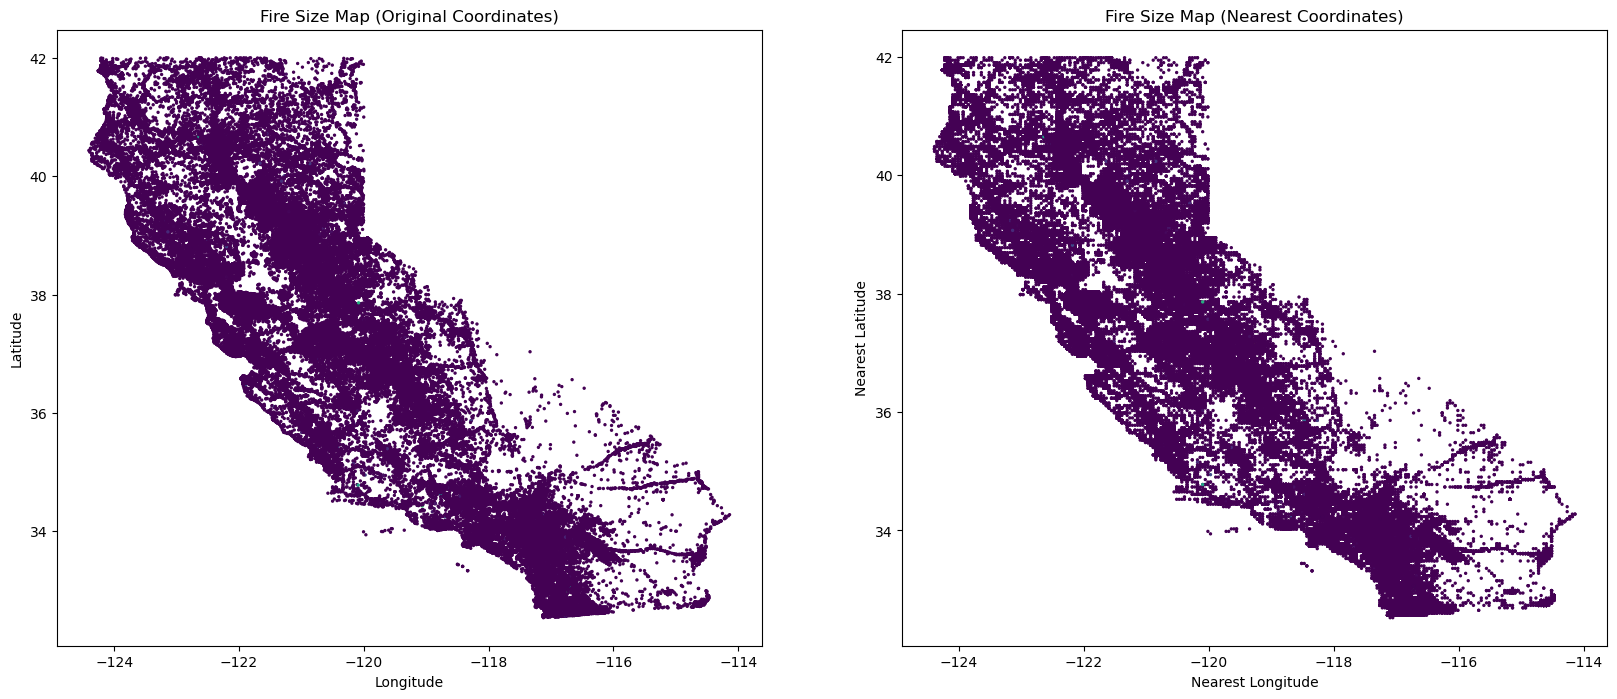

In [133]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the first scatter plot
axes[0].scatter(summary_fire['LONGITUDE'], summary_fire['LATITUDE'], c=summary_fire['min_FIRE_SIZE'], s=2)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Fire Size Map (Original Coordinates)')

# Plot the second scatter plot
axes[1].scatter(summary_fire['NEAREST_LON'], summary_fire['NEAREST_LAT'], c=summary_fire['min_FIRE_SIZE'], s=2)
axes[1].set_xlabel('Nearest Longitude')
axes[1].set_ylabel('Nearest Latitude')
axes[1].set_title('Fire Size Map (Nearest Coordinates)')

plt.show()

In [134]:
log_save_path = '../../Logs/Clean_Extended_Data/'
# Ensure the log directory exists
if not os.path.exists(log_save_path):
    os.makedirs(log_save_path)
with open(f'{log_save_path}/clean_fire_data_log.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))